# Raw data from policy-based self-play

#### With a heuristic policy

We let the HeuristicPolicy play against itself to get some quick although not so high-quality training data. The policy and value evaluations stem from the heuristic policy itself.

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import random
import numpy as np
import tensorflow as tf

from aegomoku.gomoku_game import GomokuGame
from aegomoku.gomoku_board import GomokuBoard
from aegomoku.policies.primary_detector import PrimaryDetector
from aegomoku.gomoku_game import RandomBoardInitializer
from aegomoku.policies.heuristic_policy import HeuristicPolicy
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
BOARD_SIZE=15
tight = HeuristicPolicy(15, .9)
loose = HeuristicPolicy(15, .4)
evaluator = HeuristicPolicy(15, 0,)
primary = PrimaryDetector(BOARD_SIZE)

# Initial board: 4 random stones in thw central square
rbi = RandomBoardInitializer(BOARD_SIZE, 4, 5, 9, 5, 9)
game = GomokuGame(BOARD_SIZE, initializer=rbi)

In [20]:
def is_critical(state, value_threshold):
    current_player_policy = primary.call(state)[:, :, :, 3]
    other_player_policy = primary.call(state)[:, :, :, 4]
    current_max = np.max(current_player_policy, axis=None)
    other_max = np.max(other_player_policy, axis=None)
    return max(current_max, other_max) >= value_threshold

In [21]:
def create_sample(the_board: GomokuBoard):
    position = [stone.i for stone in the_board.stones]
    # state = np.expand_dims(the_board.canonical_representation(), 0).astype(float)
    probs, value = evaluator.evaluate(the_board.canonical_representation())
    probs = (np.array(probs)*255).astype(np.uint8)
    value = value.numpy()
    return position, probs, value

In [22]:
def one_game(verbose=False, value_threshold: int=0):
    game_data = []
    board = game.get_initial_board()
    players = [tight, loose]
    pointer = 0
    state = np.expand_dims(board.canonical_representation(), 0).astype(float)
    max_stones = 80
    num_stones = 0
    while tight.get_winner(state) is None and num_stones < max_stones:
        player = players[pointer]
        pointer = 1 - pointer
        num_stones += 1
        options = player.get_advisable_actions(state)
        move = random.choice(options)
        board.act(move)
        state = np.expand_dims(board.canonical_representation(), 0).astype(float)

        if tight.get_winner(state) is not None:
            break
        if is_critical(state, value_threshold):
            game_data.append(create_sample(board))
            if verbose:
                board.plot()
                print("MUST DEFEND")
    if num_stones < max_stones:
        if verbose:
            print([stone.i for stone in board.stones])
            print("GAME OVER")
    return game_data

In [23]:
data = []

In [46]:
for i in range(10):
    data += one_game(value_threshold=1)

In [47]:
from aegomoku.game_data import expand_trajectory

examples = expand_trajectory(data)
len(examples), len(examples[0]), examples[0][0].shape

(5992, 3, (17, 17, 3))

Next to play: BLACK
Value from BLACK's point of view: 0.9121261979237809


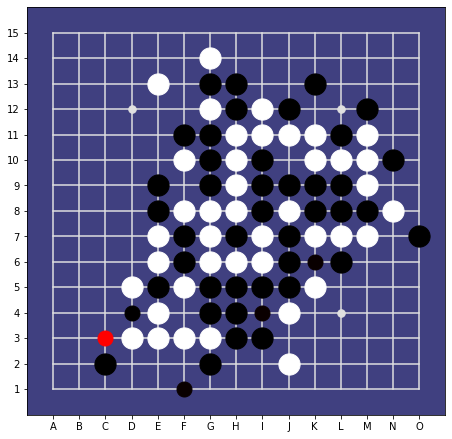

In [56]:
from aegomoku.utils import analyse_example

analyse_example(examples[random.randint(0, len(examples))])

---

---

### Reading game data from a file

In [57]:
from setup_local import DATA_PATH
filename = DATA_PATH / "selfplay" / "0" / "00001.pickle"

In [61]:
from aegomoku.game_data import read_training_data

BOARD_SIZE=15
examples, games = read_training_data(filename)
len(games), len(examples), len(examples[0]), examples[0][0].shape

(40, 12112, 3, (21, 21, 3))

Next to play: WHITE
Value from WHITE's point of view: 0.00015372689813375473


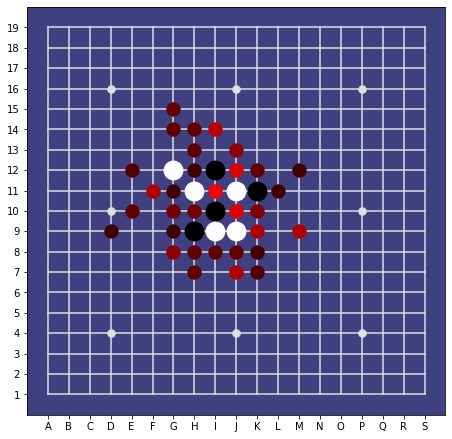

In [63]:
from aegomoku.utils import analyse_example
import random

analyse_example(examples[random.randint(0, len(examples))])